In [ ]:
!pip install lazypredict
import pandas as pd
import io
from googleapiclient.http import MediaIoBaseDownload
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import metrics
from lazypredict.Supervised import LazyRegressor
from google.colab import files
pd.reset_option

In [ ]:
df = pd.read_csv('/content/skempi_v2.csv', sep=';')
len(df.columns)

29

In [ ]:
#удаляем все строки, в которых нет температуры или константы
df = df.dropna(subset=['Temperature', 'Affinity_wt_parsed', 'Affinity_mut_parsed'])
df = df.dropna(axis=1, thresh=len(df) * 0.8) #удаляем столбцы, в которых заполнено менее 80% данных
df

,#Pdb,Mutation(s)_PDB,Mutation(s)_cleaned,iMutation_Location(s),Hold_out_proteins,Affinity_mut (M),Affinity_mut_parsed,Affinity_wt (M),Affinity_wt_parsed,Reference,Protein 1,Protein 2,Temperature,Method,SKEMPI version
0,1CSE_E_I,LI45G,LI38G,COR,Pr/PI,5.26E-11,0.00,1.12E-12,0.00,9048543,Subtilisin Carlsberg,Eglin c,294,IASP,1
1,1CSE_E_I,LI45S,LI38S,COR,Pr/PI,8.33E-12,0.00,1.12E-12,0.00,9048543,Subtilisin Carlsberg,Eglin c,294,IASP,1
2,1CSE_E_I,LI45P,LI38P,COR,Pr/PI,1.02E-07,0.00,1.12E-12,0.00,9048543,Subtilisin Carlsberg,Eglin c,294,IASP,1
3,1CSE_E_I,LI45I,LI38I,COR,Pr/PI,1.72E-10,0.00,1.12E-12,0.00,9048543,Subtilisin Carlsberg,Eglin c,294,IASP,1
4,1CSE_E_I,LI45D,LI38D,COR,Pr/PI,1.92E-09,0.00,1.12E-12,0.00,9048543,Subtilisin Carlsberg,Eglin c,294,IASP,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7080,3QIB_ABP_CD,KP9R,KP8R,COR,"TCR/pMHC,1JCK_A_B",2.4E-04,0.00,5.5E-06,0.00,12152083,I-Ek plus MCC peptide,2B4 TCR,298,SPR,2
7081,3QIB_ABP_CD,TP12A,TP11A,COR,"TCR/pMHC,1JCK_A_B",>1.1E-03,0.00,5.5E-06,0.00,12152083,I-Ek plus MCC peptide,2B4 TCR,298,SPR,2
7082,3QIB_ABP_CD,TP12S,TP11S,COR,"TCR/pMHC,1JCK_A_B",3.38E-05,0.00,5.5E-06,0.00,12152083,I-Ek plus MCC peptide,2B4 TCR,298,SPR,2
7083,3QIB_ABP_CD,TP12N,TP11N,COR,"TCR/pMHC,1JCK_A_B",4.34E-05,0.00,5.5E-06,0.00,12152083,I-Ek plus MCC peptide,2B4 TCR,298,SPR,2


In [ ]:
#кодируем наши данные
for col in ['#Pdb', 'Mutation(s)_PDB', 'Mutation(s)_cleaned',
                    'iMutation_Location(s)', 'Hold_out_proteins',
                    'Protein 1', 'Protein 2', 'Method']:
    freq = df[col].value_counts(normalize=True)
    df[col] = df[col].map(freq)
df

,#Pdb,Mutation(s)_PDB,Mutation(s)_cleaned,iMutation_Location(s),Hold_out_proteins,Affinity_mut (M),Affinity_mut_parsed,Affinity_wt (M),Affinity_wt_parsed,Reference,Protein 1,Protein 2,Temperature,Method,SKEMPI version
0,0.00,0.00,0.00,0.32,0.20,5.26E-11,0.00,1.12E-12,0.00,9048543,0.04,0.00,294,0.07,1
1,0.00,0.00,0.00,0.32,0.20,8.33E-12,0.00,1.12E-12,0.00,9048543,0.04,0.00,294,0.07,1
2,0.00,0.00,0.00,0.32,0.20,1.02E-07,0.00,1.12E-12,0.00,9048543,0.04,0.00,294,0.07,1
3,0.00,0.00,0.00,0.32,0.20,1.72E-10,0.00,1.12E-12,0.00,9048543,0.04,0.00,294,0.07,1
4,0.00,0.00,0.00,0.32,0.20,1.92E-09,0.00,1.12E-12,0.00,9048543,0.04,0.00,294,0.07,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7080,0.00,0.00,0.00,0.32,0.08,2.4E-04,0.00,5.5E-06,0.00,12152083,0.00,0.00,298,0.37,2
7081,0.00,0.00,0.00,0.32,0.08,>1.1E-03,0.00,5.5E-06,0.00,12152083,0.00,0.00,298,0.37,2
7082,0.00,0.00,0.00,0.32,0.08,3.38E-05,0.00,5.5E-06,0.00,12152083,0.00,0.00,298,0.37,2
7083,0.00,0.00,0.00,0.32,0.08,4.34E-05,0.00,5.5E-06,0.00,12152083,0.00,0.00,298,0.37,2


In [ ]:
#вводим бинарные метки
ddG=[]
for index, row in df.iterrows():
    #не стала домножать на температуру и R, так как на знак они не влияет
    G=-math.log(row['Affinity_mut_parsed']/row['Affinity_wt_parsed'])
    if G > 0:
        ddG.append(1)
    else:
        ddG.append(0)
df['ddG']=ddG
df = df.drop(columns=[0, 1], errors='ignore')
df

,#Pdb,Mutation(s)_PDB,Mutation(s)_cleaned,iMutation_Location(s),Hold_out_proteins,Affinity_mut (M),Affinity_mut_parsed,Affinity_wt (M),Affinity_wt_parsed,Reference,Protein 1,Protein 2,Temperature,Method,SKEMPI version,ddG
0,0.00,0.00,0.00,0.32,0.20,5.26E-11,0.00,1.12E-12,0.00,9048543,0.04,0.00,294,0.07,1,0
1,0.00,0.00,0.00,0.32,0.20,8.33E-12,0.00,1.12E-12,0.00,9048543,0.04,0.00,294,0.07,1,0
2,0.00,0.00,0.00,0.32,0.20,1.02E-07,0.00,1.12E-12,0.00,9048543,0.04,0.00,294,0.07,1,0
3,0.00,0.00,0.00,0.32,0.20,1.72E-10,0.00,1.12E-12,0.00,9048543,0.04,0.00,294,0.07,1,0
4,0.00,0.00,0.00,0.32,0.20,1.92E-09,0.00,1.12E-12,0.00,9048543,0.04,0.00,294,0.07,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7080,0.00,0.00,0.00,0.32,0.08,2.4E-04,0.00,5.5E-06,0.00,12152083,0.00,0.00,298,0.37,2,0
7081,0.00,0.00,0.00,0.32,0.08,>1.1E-03,0.00,5.5E-06,0.00,12152083,0.00,0.00,298,0.37,2,0
7082,0.00,0.00,0.00,0.32,0.08,3.38E-05,0.00,5.5E-06,0.00,12152083,0.00,0.00,298,0.37,2,0
7083,0.00,0.00,0.00,0.32,0.08,4.34E-05,0.00,5.5E-06,0.00,12152083,0.00,0.00,298,0.37,2,0


In [ ]:
df.dtypes

,0
#Pdb,float64
Mutation(s)_PDB,float64
Mutation(s)_cleaned,float64
iMutation_Location(s),float64
Hold_out_proteins,float64
Affinity_mut (M),object
Affinity_mut_parsed,float64
Affinity_wt (M),object
Affinity_wt_parsed,float64
Reference,object


In [ ]:
#удалим всё, что не является числами, температуру переведем в числовой формат
Temperature=[]
Reference=[]
df= df.drop(columns=['Affinity_mut (M)','Affinity_wt (M)', 'Reference'], errors='ignore')
for i in df['Temperature']:
    Temperature.append(float(i.split('(')[0]))
df['Temperature']=Temperature
df.dtypes

,0
#Pdb,float64
Mutation(s)_PDB,float64
Mutation(s)_cleaned,float64
iMutation_Location(s),float64
Hold_out_proteins,float64
Affinity_mut_parsed,float64
Affinity_wt_parsed,float64
Protein 1,float64
Protein 2,float64
Temperature,float64


In [25]:
#опционально, так как признаков и так осталось достаточно мало
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
import shap

X = df.drop(columns=['ddG'])  # Признаки
y = df['ddG']                # Бинарная метка

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Random Forest для оценки важности признаков
model_rf = RandomForestClassifier(random_state=42)
model_rf.fit(X, y)
importance = pd.DataFrame({'Feature': X.columns, 'Importance': model_rf.feature_importances_})
print(importance.sort_values('Importance', ascending=False))

# SHAP-анализ для интерпретируемости
explainer = shap.TreeExplainer(model_rf)
shap_values = explainer.shap_values(X)

                  Feature  Importance
5     Affinity_mut_parsed        0.47
6      Affinity_wt_parsed        0.20
0                    #Pdb        0.07
3   iMutation_Location(s)        0.05
7               Protein 1        0.05
8               Protein 2        0.04
4       Hold_out_proteins        0.03
1         Mutation(s)_PDB        0.03
10                 Method        0.03
2     Mutation(s)_cleaned        0.02
9             Temperature        0.01
11         SKEMPI version        0.01


In [26]:
from lazypredict.Supervised import LazyClassifier
from sklearn.model_selection import train_test_split
X = df.drop(columns=['ddG'])  # Признаки
y = df['ddG']                # Целевая переменная

# Разделение на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Автоматическое обучение и сравнение моделей
clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)
models, predictions = clf.fit(X_train, X_test, y_train, y_test)

# Вывод результатов (сортировка по 'Accuracy')
print(models.sort_values('Accuracy', ascending=False))

  0%|          | 0/32 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 1175, number of negative: 4260
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001215 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 868
[LightGBM] [Info] Number of data points in the train set: 5435, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216191 -> initscore=-1.288001
[LightGBM] [Info] Start training from score -1.288001
                               Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
BaggingClassifier                  0.98               0.95     0.95      0.98   
LGBMClassifier                     0.98               0.96     0.96      0.98   
XGBClassifier                      0.97               0.95     0.95      0.97   
DecisionTreeClassifier             0.97               0.95     0.95      0.97   
RandomForestClassifier  

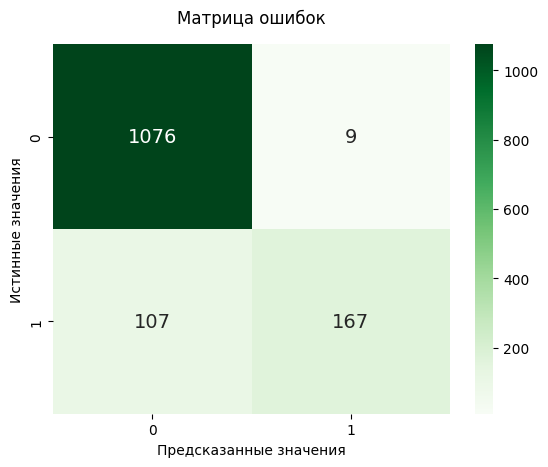

In [27]:
#Посмотрим на обучпемость наших трех лидеров. Начнем с BaggingClassifer
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.datasets import make_classification
model = BaggingClassifier(n_estimators=100, random_state=42, max_samples=200)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', annot_kws={'fontsize': 14})
plt.ylabel('Истинные значения')
plt.xlabel('Предсказанные значения')
plt.title('Матрица ошибок', pad=15)
plt.show()


In [28]:
report = classification_report(y_test, model.predict(X_test))
print(report)

              precision    recall  f1-score   support

           0       0.91      0.99      0.95      1085
           1       0.95      0.61      0.74       274

    accuracy                           0.91      1359
   macro avg       0.93      0.80      0.85      1359
weighted avg       0.92      0.91      0.91      1359



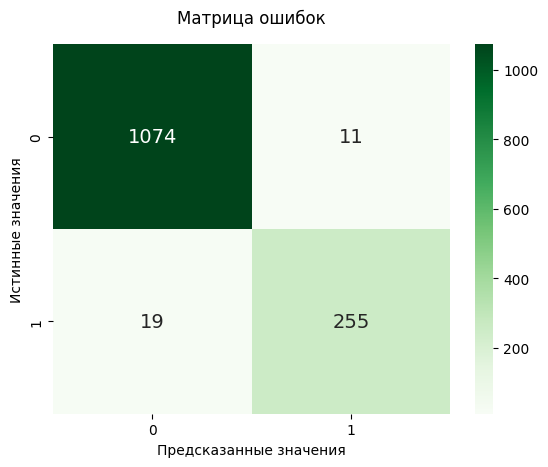

In [33]:
#теперь XGBCClassifier
import xgboost as xgb
model = xgb.XGBClassifier()
model.fit(X_train.values, y_train.values)
y_pred_model = model.predict(X_test.values)
cm = confusion_matrix(y_test, y_pred_model)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', annot_kws={'fontsize': 14})
plt.ylabel('Истинные значения')
plt.xlabel('Предсказанные значения')
plt.title('Матрица ошибок', pad=15)
plt.show()


In [ ]:
report = classification_report(y_test, model.predict(X_test.values))
print(report)

[LightGBM] [Info] Number of positive: 1175, number of negative: 4260
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000377 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 857
[LightGBM] [Info] Number of data points in the train set: 5435, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216191 -> initscore=-1.288001
[LightGBM] [Info] Start training from score -1.288001


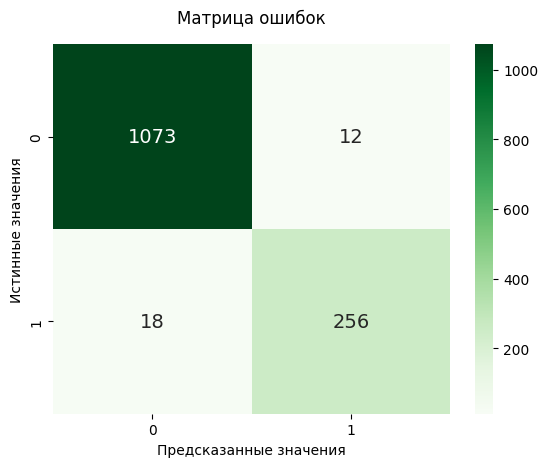

In [34]:
import lightgbm as lgb
from lightgbm import LGBMClassifier
model = lgb.LGBMClassifier()
model.fit(X_train.values, y_train.values)
y_pred_model = model.predict(X_test.values)
cm = confusion_matrix(y_test, y_pred_model)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', annot_kws={'fontsize': 14})
plt.ylabel('Истинные значения')
plt.xlabel('Предсказанные значения')
plt.title('Матрица ошибок', pad=15)
plt.show()

In [35]:
report = classification_report(y_test, model.predict(X_test.values))
print(report)

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1085
           1       0.96      0.93      0.94       274

    accuracy                           0.98      1359
   macro avg       0.97      0.96      0.97      1359
weighted avg       0.98      0.98      0.98      1359

